In [1]:
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import plotting, plotting_util, pairs_plotting, prim
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy, Scenario)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench.util.utilities import (save_results, load_results)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# define problem formulation
model, functions = get_model_for_problem_formulation(2)

In [6]:
# set up robust functions
import functools
import numpy as np


def robustness(direction, threshold, data):
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

Expected_Annual_Damage = functools.partial(robustness, 'SMALLER', 1*10**6)
Dike_Investment_Costs = functools.partial(robustness, 'SMALLER', 10*10**8)	
RfR_Investment_Costs = functools.partial(robustness, 'SMALLER', 1)	
Evacuation_Costs = functools.partial(robustness, 'SMALLER', 50000)	
Expected_Number_of_Deaths = functools.partial(robustness, 'SMALLER', 0.5)
Minimum_water_level_full_network = functools.partial(robustness, 'LARGER', 4.5)

In [7]:
# Defining the robustness functions
robust = [ScalarOutcome('Expected_Damage', kind=ScalarOutcome.MAXIMIZE, variable_name='Expected Annual Damage',
                        function=Expected_Annual_Damage),
          ScalarOutcome('Dike_Costs', kind=ScalarOutcome.MAXIMIZE,variable_name='Dike Investment Costs',
                        function=Dike_Investment_Costs),
          ScalarOutcome('RfR_Costs', kind=ScalarOutcome.MAXIMIZE, variable_name='RfR Investment Costs', 
                        function=RfR_Investment_Costs),
          ScalarOutcome('Evacuation_Costs', kind=ScalarOutcome.MAXIMIZE, variable_name='Evacuation Costs',
                        function=Evacuation_Costs),
          ScalarOutcome('Number_of_Deaths', kind=ScalarOutcome.MAXIMIZE, variable_name='Expected Number of Deaths',
                        function=Expected_Number_of_Deaths),
          ScalarOutcome('wl', kind=ScalarOutcome.MAXIMIZE, variable_name='Minimum water level full network',
                        function=Minimum_water_level_full_network)   
          ]

In [3]:
# set up convergence metrics
convergence_metrics = [HyperVolume(minimum=[0,0,0,0,0,0], maximum=[1, 1, 1, 1,1,1]), EpsilonProgress()]

In [8]:
# function to check epsilon and convergence
def plot_epsilon_and_convergence(convergencedata):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
    ax1.plot(convergencedata.nfe, convergencedata.epsilon_progress)
    ax1.set_ylabel('$\epsilon$-progress')
    ax2.plot(convergencedata.nfe, convergencedata.hypervolume)
    ax2.set_ylabel('hypervolume')

    ax1.set_xlabel('number of function evaluations')
    ax2.set_xlabel('number of function evaluations')
    plt.show()

In [10]:
# load scenarios from PRIM analysis
import pickle

with open('ANALYSIS_results/02_PRIM_scenarios.txt', 'rb') as file:
    scenarios = pickle.load(file)

In [11]:
# perform MORO
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    robust_results, convergence = evaluator.robust_optimize(robust, 
                                                    scenarios=scenarios,
                                                    nfe = 10000,
                                                    epsilons=[0.05, ] * len(robust),
                                                    convergence=convergence_metrics)

SyntaxError: invalid syntax (<ipython-input-11-39bd8f6dfc7e>, line 9)

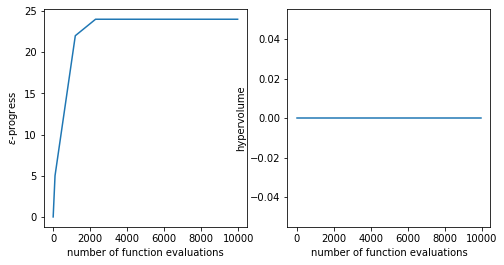

In [9]:
# inspect convergence
plot_epsilon_and_convergence(convergence)

In [ ]:
# robust policies
robust_results

In [ ]:
# view plot
from ema_workbench.analysis import parcoords

outcomes = robust_results.loc[:,['Fmax_P', 'Futility', 'Fintertia', 'Freliability']]
limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

In [ ]:
# save results
result.to_csv('ANALYSIS_results/03_MORO_results.csv')
convergence.to_csv('ANALYSIS_results/03_MORO_convergence.csv')

In [4]:
result = pd.read_csv('03_MORO_results.csv')
convergence = pd.read_csv('03_MORO_convergence.csv')

In [5]:
result

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected_Damage,Dike_Costs,RfR_Costs,Evacuation_Costs,Number_of_Deaths,wl
0,0,0,0,0,1,1,1,1,1,1,...,8,10,3,7,0.967626,1.0,0.0,1.0,1.0,0.140288
1,1,1,0,1,1,0,1,1,1,1,...,2,10,8,6,0.935252,1.0,0.0,1.0,1.0,1.000000


In [6]:
convergence

,Unnamed: 0,hypervolume,epsilon_progress,nfe
0,0,0.0,0,0
1,1,0.0,5,100
2,2,0.0,22,1195
3,3,0.0,24,2288
4,4,0.0,24,3383
5,5,0.0,24,4473
6,6,0.0,24,5572
7,7,0.0,24,6668
8,8,0.0,24,7766
9,9,0.0,24,8863


In [ ]:
# get the policies
policies = robust_results[['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]
policies_list = [Policy(str(index), **row.to_dict()) for index, row in policies.iterrows()]
policies_list

In [ ]:
# re-evaluate
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment_robust_2, result_robust_2 = evaluator.perform_experiments(1000,
                                         policies = policies_list)

In [ ]:
# get plot
def prepair_data(experiment, results):
    df = pd.DataFrame(results)
    data = pd.concat([experiment, df], 1)
    results_p = pd.DataFrame()
    results_p['maxp'] = data.groupby('policy').apply(lambda x: maxp(x.max_P))
    results_p['utility'] = data.groupby('policy').apply(lambda x: utility(x.utility))
    results_p['intertia'] = data.groupby('policy').apply(lambda x: inertia(x.intertia))
    results_p['reliability'] = data.groupby('policy').apply(lambda x: reliability(x.reliability))
    
    return results_p
    
da = prepair_data(experiment_robust_2, result_robust_2)
limits = parcoords.get_limits(da)
axes = parcoords.ParallelAxes(limits)
axes.plot(da)
plt.show()